<a href="https://colab.research.google.com/github/tulaycetin/Veri_Azaltma_Yontemleri/blob/main/Veri_Azaltma_yontemlerii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Kütüphanelerin Yüklenmesi**

In [ ]:
# Gerekli kütüphanelerin yüklenmesi
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report ,roc_curve,roc_auc_score

# ***2. Veri Setinin İndirilmesi ve İlk İncelemesikalın metin***

In [ ]:
# Veri Setini İndirme ve Ön İnceleme
# ---------------------------

# Hücre 2: Veri setini yükle ve ön inceleme
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print("Şekil:", df.shape)
print("\nEksik Değer Sayıları:\n", df.isnull().sum())
display(df.head())




Şekil: (891, 12)

Eksik Değer Sayıları:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **3. Eksik Verilerin MICE Yöntemiyle Doldurulması**

**Açıklama:** Her sayısal sütundaki eksikleri, diğer sütunlarla kurulan regresyon modelleriyle ardışık (chained) şekilde tahmin eder.

---
“Basit ortalama yerine MICE; veri tutarlılığını artırır.”


In [ ]:
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer'ı etkinleştirir.
from sklearn.impute import IterativeImputer

# Hücre 3: Sayısal sütunlardaki eksikleri IterativeImputer ile doldur
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = IterativeImputer(random_state=42)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


 **Kategoriklerin Sayısallaştırılması**

 Yöntem: One-Hot Encoding

Açıklama: pd.get_dummies(drop_first=True) ile kategorik sütunları 0/1 ikili sütunlara çevirir, dummy trap önlenir.

In [ ]:
# Hücre 4: One-hot encoding ile kategorikleri sayısala çevir
df = pd.get_dummies(df, drop_first=True)


# **4. Hedef ve Bağımsız Değişkenlerin Ayrılması**

In [ ]:

# Hücre 5: Özellik ve hedef matrisini hazırla
y = df['Survived']
X = df.drop(columns=['Survived'])


"\ny = (df_imputed['Survived'] >= 0.5).astype(int)\nX = df_imputed.drop(columns=['Survived'])"

# **5. Özellik Ölçekleme (Eksik)**

Yöntem: StandardScaler

Açıklama: Tüm sütunlar ortalaması 0, sabit sapması 1 olacak biçimde normalize edilir.



---
Mesafe-temelli yöntemler (PCA, LDA, Decision Tree dışı) için önemli.


In [ ]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ***Boyut İndirgeme Yöntemleri***

# **6. PCA ile Boyut İndirgeme**

PCA: Verideki varyansın %90’ını koruyacak şekilde boyut indirgeme yapıyor.

Amaç: Gürültüyü azaltıp hesaplama yükünü hafifletmek.


In [ ]:
from sklearn.decomposition import PCA

# PCA ile boyut indirgeme (varyansın %90'ını koru)
pca = PCA(n_components=0.90, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print("PCA sonrası bileşen sayısı:", X_pca.shape[1])


PCA sonrası bileşen sayısı: 718


# **7. LDA ile Boyut İndirgeme**



*   LDA: Sınıflar arası ayrımı maksimize eden doğrusal kombinasyonlar bulur.
*  İkili sınıflandırma için en fazla 1 bileşen verir (sınıf sayısı − 1).



In [ ]:
# Win_Prob'u sınıfa çeviriyoruz (örnek: 0.5 üstü = 'kazanır')
y_class = y.values

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_scaled, y_class)

print("LDA sonrası boyut sayısı:", X_lda.shape[1])


LDA sonrası boyut sayısı: 1


# **8. Özellik Seçimi (SelectKBest + mutual_info_classif)**

Mutual information (karşılıklı bilgi) tabanlı en iyi 20 özelliği seçiyoruz. Bu, hedef değişkenle en fazla bağımlılığı taşıyan özellikleri belirler.

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# En iyi 20 özelliği seçecek
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y_class)

# Seçilen sütun isimlerini görelim
selected_columns = X.columns[selector.get_support()]
print("Seçilen öznitelikler:\n", selected_columns)


Seçilen öznitelikler:
 Index(['Pclass', 'Age', 'Fare',
       'Name_Carter, Mrs. Ernest Courtenay (Lilian Hughes)',
       'Name_Duran y More, Miss. Asuncion',
       'Name_Jacobsohn, Mrs. Sidney Samuel (Amy Frances Christy)',
       'Name_Jonkoff, Mr. Lalio', 'Name_Robbins, Mr. Victor',
       'Name_West, Miss. Constance Mirium', 'Name_Widener, Mr. Harry Elkins',
       'Sex_male', 'Ticket_111427', 'Ticket_17464', 'Ticket_31027',
       'Ticket_341826', 'Ticket_345774', 'Ticket_36866', 'Ticket_A.5. 18509',
       'Ticket_SW/PP 751', 'Cabin_B96 B98'],
      dtype='object')


# **Decision Tree**


===Orijinal===
Accuracy: 0.849 — AUC: 0.831
Confusion Matrix:
 [[100  10]
 [ 17  52]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       110
         1.0       0.84      0.75      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



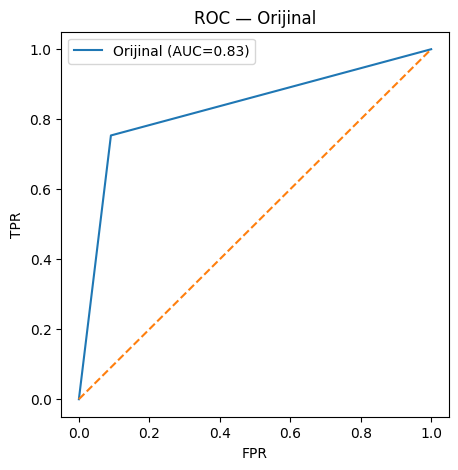


===PCA===
Accuracy: 0.687 — AUC: 0.681
Confusion Matrix:
 [[78 32]
 [24 45]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.74       110
         1.0       0.58      0.65      0.62        69

    accuracy                           0.69       179
   macro avg       0.67      0.68      0.68       179
weighted avg       0.70      0.69      0.69       179



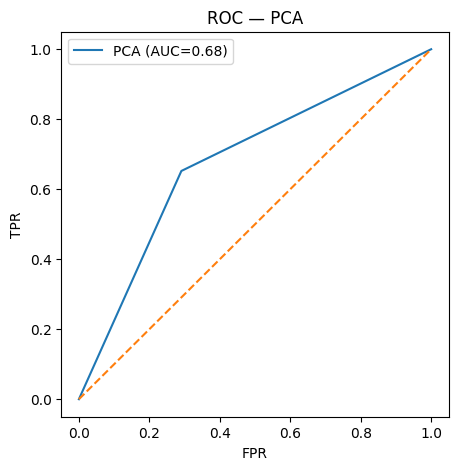


===LDA===
Accuracy: 0.648 — AUC: 0.627
Confusion Matrix:
 [[79 31]
 [32 37]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.72      0.71       110
         1.0       0.54      0.54      0.54        69

    accuracy                           0.65       179
   macro avg       0.63      0.63      0.63       179
weighted avg       0.65      0.65      0.65       179



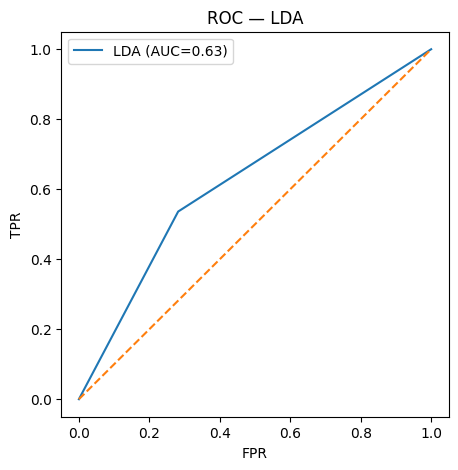


===SelectKBest(20)===
Accuracy: 0.838 — AUC: 0.833
Confusion Matrix:
 [[94 16]
 [13 56]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.85      0.87       110
         1.0       0.78      0.81      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



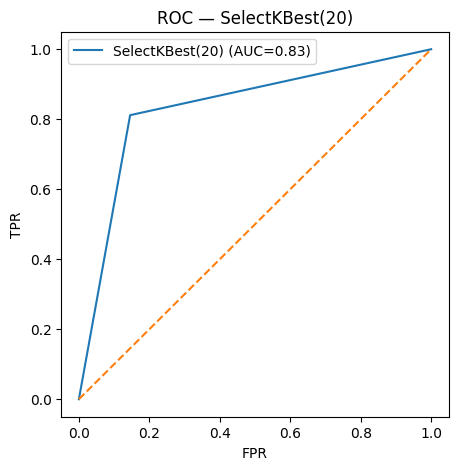

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def DTClassifierModel(X, y, threshold=0.5, name="Model"):
    # train/test split
    # Fonksiyon içinde en başta:
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # one-hot kodlama (gerekiyorsa)
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test  = pd.get_dummies(X_test, drop_first=True)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # model
    dt = DecisionTreeClassifier(
        criterion='gini',
        max_depth=None,
        class_weight='balanced',
        random_state=42
    )
    dt.fit(X_train, y_train)

    # olasılık tahmini ve sınıf tahmini
    y_proba = dt.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= threshold).astype(int)

    # metrikler
    acc     = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"\n==={name}===\nAccuracy: {acc:.3f} — AUC: {roc_auc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # ROC çizimi
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC — {name}')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

    return {'model': dt, 'accuracy': acc, 'auc': roc_auc}

# --- (6) Tüm veri kümelerini değerlendir ---
datasets = {
    'Orijinal': X,
    'PCA': X_pca,
    'LDA': X_lda,
    'SelectKBest(20)': X_selected
}


results_dt = {}
for name, X_df in datasets.items():
    results_dt[name] = DTClassifierModel(X_df, y, name=name)


